# Redes Neuronales - TP2
## Ej 5

Siguiendo el trabajo de Hinton y Salakhutdinov (2006), entrene una máquina restringida
de Boltzmann con imágenes de la base de datos MNIST. Muestre el error de
recontruccion durante el entrenamiento, y ejemplos de cada uno de los dígitos
reconstruidos.




La MRB se puede pensar como una red feedfoward de 4 capas, en vez de pensarla como una de 2 capas con pesos simétricos. $v$ es la capa visible y $h$ es la oculta, y tenemos un $\hat{v}$ y $\hat{h}$, que son las estimaciones. 

Las fórmulas que hay que seguir son las siguientes:

$$
m_i = \text{pixel}_i
$$

$$
v_i \sim  \mathcal{N}(m_i , 1)
$$

$$
P_r (j) = g(\sum _i w_{ij} v_i + b_j) \quad \quad g (x) = \frac{1}{1+e^{-x}}
$$

$$
h(j) = 
\begin{cases}
1 \quad \text{con probabilidad} \quad P_r 
\\
0 \quad  \text{con probabilidad}\quad 1-P_r 
\end{cases}
$$

$$
\text{guardar} \quad (v_i , h_j)_{data}
$$

Luego se repite pero para obtener las estimaciones

$$
m_i = \sum _j w_{ij} v_i + b_i
$$

$$
\hat{v}_i \sim  \mathcal{N}(m_i , 1)
$$

$$
P_r (j) = g(\sum _i w_{ij} v_i + b_j) \quad \quad g (x) = \frac{1}{1+e^{-x}}
$$

$$
\hat{h}(j) = 
\begin{cases}
1 \quad \text{con probabilidad} \quad P_r 
\\
0 \quad  \text{con probabilidad}\quad 1-P_r 
\end{cases}
$$

$$
\text{guardar} \quad (v_i , h_j)_{reconstruccion}
$$

Al final se hace

$$
\Delta w_{ij}= \eta ( \left\langle v_i h_j \right\rangle - \left\langle \hat{v_i} \hat{h_j} \right\rangle)
$$

$$
b_i= \eta ( \left\langle v_i \right\rangle - \left\langle \hat{v_i} \right\rangle)
$$

$$
\Delta w_{ij}= \eta ( \left\langle v_i h_j \right\rangle - \left\langle \hat{v_i} \hat{h_j} \right\rangle)
$$
$$
b_j= \eta ( \left\langle  h_j \right\rangle - \left\langle  \hat{h_j} \right\rangle)
$$

In [7]:
import numpy as np


In [8]:
def _sigmoid(x):
    # Numéricamente estable: recortamos la entrada para evitar overflow en exp
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-x))


class RBM:
  """
  RBM con visibles gaussianas (sigma=1) y ocultas binarias.

  Pequeñas protecciones numéricas:
    - recorte de entradas a la sigmoide para evitar overflow
    - recorte de medias de visibles antes de muestrear
  """

  def __init__(self, n_visible, n_hidden, lr=0.1, rng=None):
      self.n_visible = int(n_visible)
      self.n_hidden = int(n_hidden)
      self.lr = float(lr)
      self.rng = np.random.RandomState(None) if rng is None else rng

      # pesos: forma (n_visible, n_hidden)
      # inicialización pequeña
      self.W = 0.01 * self.rng.randn(self.n_visible, self.n_hidden).astype(np.float32)
      # sesgos visibles y ocultos
      self.b = np.zeros(self.n_visible, dtype=np.float32)
      self.c = np.zeros(self.n_hidden, dtype=np.float32)

  def v_to_h(self, pixeles, sample=True, sample_visible=False):
      """Paso v -> h.
      Args:
        pixeles: array (batch, n_visible) con las medias m_i (por ejemplo los pixeles en [0,1])
        sample: si True, devuelve muestras binarias de h además de las probabilidades
        sample_visible: si True, primero muestrea visibles v ~ N(m,1); si False usa m directamente
      Returns:
        h_prob, h_samp
      """
      m = np.asarray(pixeles, dtype=np.float32)  # media = pixel_i
      if sample_visible:
          # recortamos m para evitar medias absurdas antes de añadir ruido
          m_clipped = np.clip(m, -10.0, 10.0)
          v = m_clipped + self.rng.randn(*m.shape).astype(np.float32)
      else:
          v = m

      pre = np.dot(v, self.W) + self.c
      # evitar overflow numerico en la sigmoide
      pre = np.clip(pre, -50.0, 50.0)
      h_prob = _sigmoid(pre)
      h_samp = None
      if sample:
          h_samp = (self.rng.rand(*h_prob.shape) < h_prob).astype(np.float32)
      return h_prob, h_samp

  def h_to_v(self, h, sample=True):
      """Paso h -> v.
      Args:
        h: array (batch, n_hidden) -- puede ser probabilidades o muestras
        sample: si True, devuelve muestras gaussianas v ~ N(mean, 1); si False solo la media
      Returns:
        v_mean, v_samp
      """
      h = np.asarray(h, dtype=np.float32)
      v_mean = np.dot(h, self.W.T) + self.b
      # recortamos v_mean para evitar que crezca descontroladamente
      v_mean = np.clip(v_mean, -10.0, 10.0)
      v_samp = None
      if sample:
          v_samp = v_mean + self.rng.randn(*v_mean.shape).astype(np.float32)
      return v_mean, v_samp

  def gradiente(self, v0, h0_prob, v1, h1_prob):
      """CD-1: calcula dW, db, dc usando probabilidades (h0_prob, h1_prob).
      Args:
        v0: batch de datos (N, n_visible)
        h0_prob: P(h|v0) (N, n_hidden)
        v1: reconstrucción de v (muestra) (N, n_visible)
        h1_prob: P(h|v1) (N, n_hidden)
      Returns:
        dW, db, dc (ya multiplicados por lr)
      """
      v0 = np.asarray(v0, dtype=np.float32)
      v1 = np.asarray(v1, dtype=np.float32)
      h0_prob = np.asarray(h0_prob, dtype=np.float32)
      h1_prob = np.asarray(h1_prob, dtype=np.float32)

      batch = float(v0.shape[0])
      pos_assoc = np.dot(v0.T, h0_prob) / batch
      neg_assoc = np.dot(v1.T, h1_prob) / batch

      dW = self.lr * (pos_assoc - neg_assoc)
      db = self.lr * (v0.mean(axis=0) - v1.mean(axis=0))
      dc = self.lr * (h0_prob.mean(axis=0) - h1_prob.mean(axis=0))
      return dW, db, dc

  def reconstruct(self, v):
      """Reconstrucción determinística: v -> h_prob -> v_mean."""
      h_prob, _ = self.v_to_h(v, sample=False, sample_visible=False)
      v_mean, _ = self.h_to_v(h_prob, sample=False)
      return v_mean
  

  def train_loop(self, data, max_epochs=50, batch_size=64, tol=1e-4, verbose=True):
          """Superloop de entrenamiento que itera por épocas y batches.
          Por defecto hace CD-1 usando:
            - h0_prob = P(h|v0)
            - h0_samp ~ Bernoulli(h0_prob)
            - v1_samp ~ N(dot(h0_samp,W^T)+b, 1)
            - h1_prob = P(h|v1_samp)
          Y usa (v0, h0_prob) y (v1_samp, h1_prob) para calcular gradientes.
          """
          X = np.asarray(data, dtype=np.float32)
          N = X.shape[0]
          # cubrir todo el dataset (incluyendo última fracción si N no es múltiplo de batch_size)
          n_batches = int(np.ceil(float(N) / float(batch_size)))

          epoch_errors = []
          prev_epoch_err = None

          for epoch in range(1, max_epochs + 1):
              perm = self.rng.permutation(N)
              epoch_err = 0.0
              for b in range(n_batches):
                  start = b * batch_size
                  stop = min((b + 1) * batch_size, N)
                  idx = perm[start:stop]
                  if idx.size == 0:
                      continue
                  v0 = X[idx]

                  # Paso 1: v -> h (obtener probabilidades y muestras)
                  # Usamos sample=True para obtener muestras necesarias al cálculo del gradiente
                  h0_prob, h0_samp = self.v_to_h(v0, sample=True, sample_visible=False)

                  # Paso 2: h -> v (reconstrucción basada en la muestra) para la fase negativa del gradiente
                  v1_mean_sample, v1_samp = self.h_to_v(h0_samp, sample=True)

                  # Paso 3: v(recon) -> h (prob negative)
                  h1_prob, _ = self.v_to_h(v1_samp, sample=False, sample_visible=False)

                  # Paso 4: calcular gradientes usando probabilidades para las ocultas
                  dW, db, dc = self.gradiente(v0, h0_prob, v1_samp, h1_prob)

                  # Aplicar actualizaciones (opcional: clip de actualizaciones para prevenir explosión)
                  self.W += dW
                  self.b += db
                  self.c += dc

                  # ---- Medición del error para monitoreo: usar reconstrucción determinística ----
                  # Esto evita comparar el MSE ruidoso (entrenamiento) contra el MSE determinístico (test).
                  v1_mean_det, _ = self.h_to_v(h0_prob, sample=False)
                  batch_err = np.mean((v0 - v1_mean_det) ** 2)
                  epoch_err += batch_err

              epoch_err /= float(n_batches)
              epoch_errors.append(epoch_err)

              if verbose:
                  print(f"Epoch {epoch:3d}/{max_epochs} - recon_error: {epoch_err:.6f}")

              # Criterio de convergencia: cambio pequeño en el error promedio por época
              if prev_epoch_err is not None and abs(prev_epoch_err - epoch_err) < tol:
                  if verbose:
                      print("Converged (tol reached). Stopping training.")
                  break
              prev_epoch_err = epoch_err

          return epoch_errors


## Entrenamiento con MNIST

En estas celdas cargamos MNIST, preprocesamos las imágenes (normalización y aplanado),
entrenamos la RBM usando `train_loop` implementado más arriba y luego mostramos
el error de reconstrucción por época y algunas reconstrucciones de ejemplo.

In [9]:
# Preparar MNIST y entrenar la RBM
from keras.datasets import mnist
import matplotlib.pyplot as plt

# Cargar MNIST
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Preprocesamiento:
# - aplanar
# - normalizar: dejamos los pixeles en rango [0,1] y usamos la interpretación de visibles gaussianas
#   con media igual al pixel (m_i = pixel_i). Para respetar eso, simplemente usamos los valores
#   en [0,1] como medias cuando alimentamos v_to_h en la clase.

train_X = train_X.astype(np.float32) / 255.0
test_X = test_X.astype(np.float32) / 255.0

X = train_X.reshape(-1, 28 * 28)

# Instanciar RBM
#rbm = RBM(28 * 28, 256, lr=0.01)

# Entrenar
#errs = rbm.train_loop(X, max_epochs=25, batch_size=128, tol=1e-5, verbose=True)

# Guardar errores y modelo en memoria
#train_errors = errs


In [10]:
def show_recon_and_error(rbm, X, train_errors, n_show=10, title_prefix=None, test_mse=None):
    """Muestra la curva de error por época y una rejilla de `n_show` originales vs reconstrucciones.

    Args:
      rbm: instancia entrenada de RBM
      X: matriz (N, n_visible) usada para obtener los `n_show` primeros ejemplos para visualizar
      train_errors: lista de floats con el error por época
      n_show: cuántas imágenes mostrar
      title_prefix: texto opcional para anteponer al título (p. ej. clave del experimento)
      test_mse: (opcional) valor escalar de MSE sobre el set de prueba para mostrar en el plot
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Plot error (training)
    plt.figure(figsize=(6,4))
    plt.plot(train_errors, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Recon Error (MSE)')
    title = 'Recon Error por Época (train)'
    if title_prefix:
        title = f"{title_prefix} - {title}"
    if test_mse is not None:
        # mostrar test MSE en el título y en consola
        title = f"{title} | test MSE: {test_mse:.6f}"
        print(f"Test MSE: {test_mse:.6f}")
    plt.title(title)
    plt.grid(True)
    plt.show()

    # Mostrar algunas reconstrucciones (primeras n_show del conjunto X)
    n_show = int(n_show)
    orig = np.asarray(X, dtype=np.float32)[:n_show]
    recons = rbm.reconstruct(orig)

    # Clip para visualizar mejor en [0,1]
    recons = np.clip(recons, 0.0, 1.0)
    orig_disp = np.clip(orig, 0.0, 1.0)

    plt.figure(figsize=(n_show * 2, 4))
    for i in range(n_show):
        ax = plt.subplot(2, n_show, i + 1)
        plt.imshow(orig_disp[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title('Originals')

        ax = plt.subplot(2, n_show, n_show + i + 1)
        plt.imshow(recons[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title('Reconstructions')
    # repetir título para la figura de reconstrucciones
    plt.suptitle(title)
    plt.show()


--- Training h50_e100 ---
Finished h50_e100 | train_final_mse=0.036998 | test_mse=0.036864
Test MSE: 0.036864


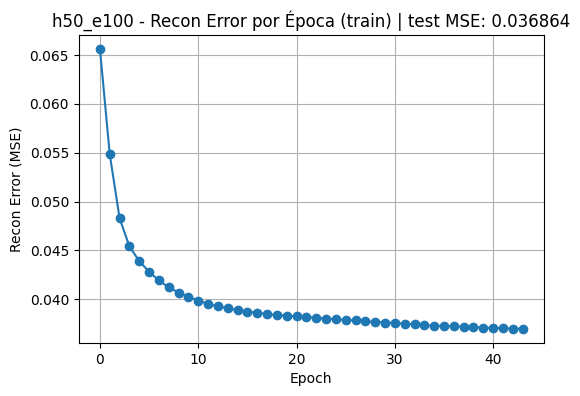

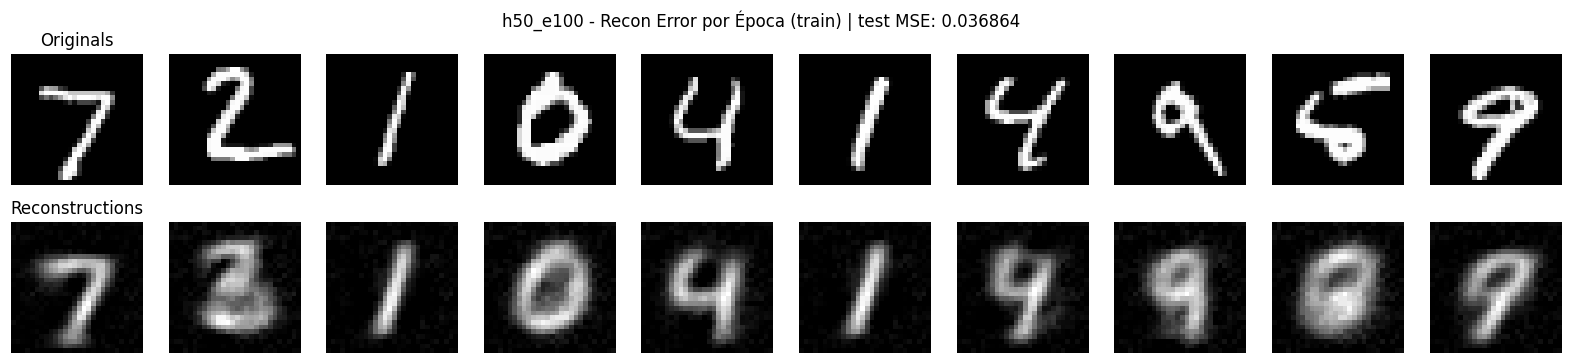

--- Training h10_e100 ---
Finished h10_e100 | train_final_mse=0.045218 | test_mse=0.045082
Test MSE: 0.045082


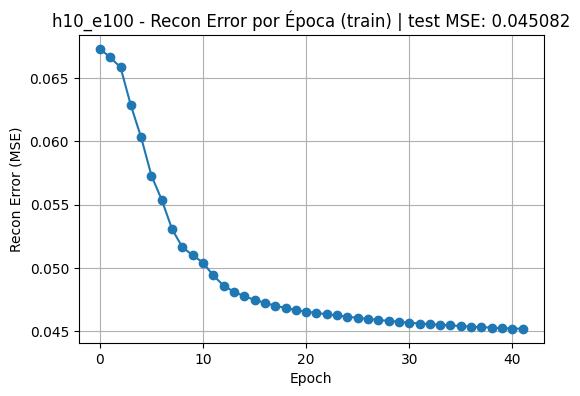

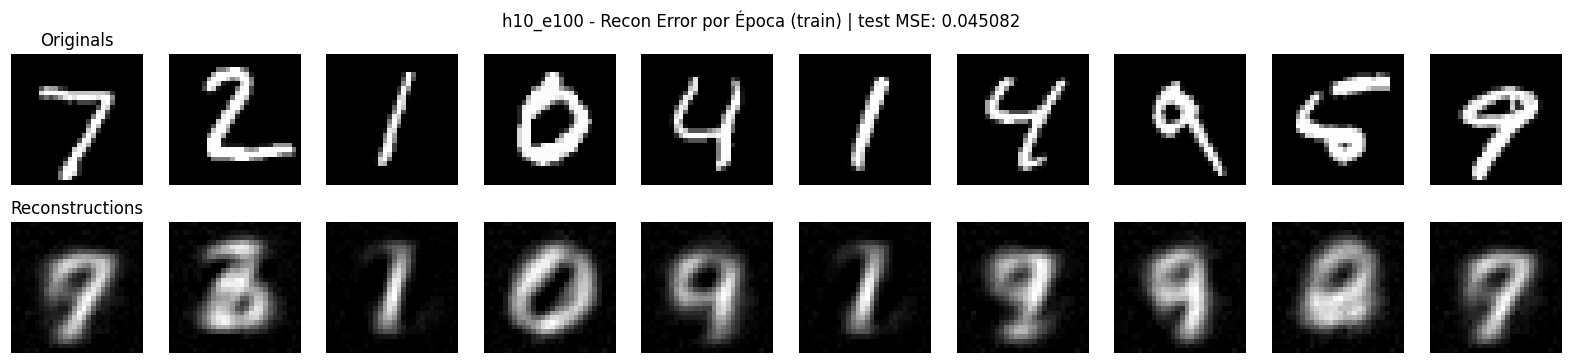

--- Training h1_e100 ---
Finished h1_e100 | train_final_mse=0.067311 | test_mse=0.067549
Test MSE: 0.067549


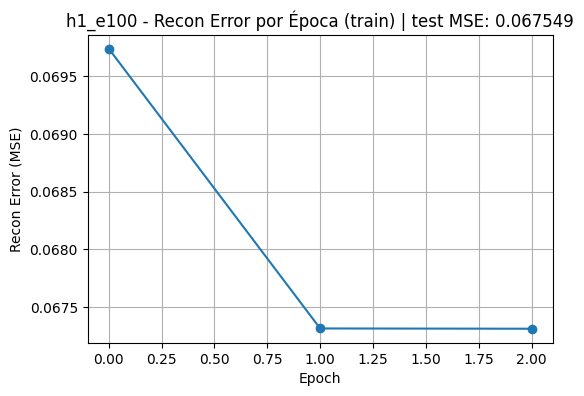

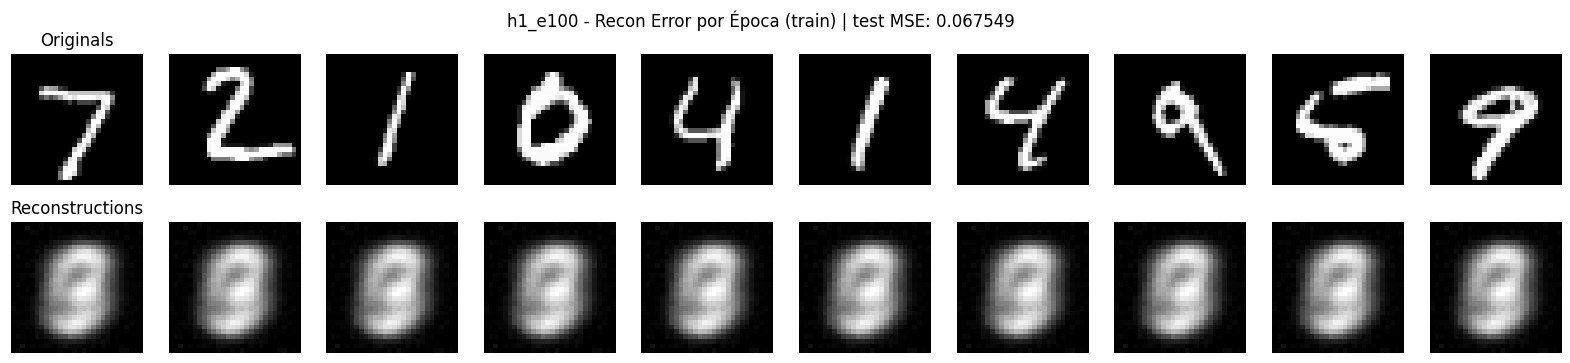

In [ ]:
# Experimentos: entrenar 9 modelos (3 tamaños ocultos x 3 números de épocas)
hidden_sizes = [400,200,100,50, 10, 1]
epochs_list = [100]
results = {}
n_show = 10

for n_hidden in hidden_sizes:
    for epochs in epochs_list:
        key = f"h{n_hidden}_e{epochs}"
        print(f"--- Training {key} ---")
        rbm = RBM(28 * 28, n_hidden, lr=0.01)
        # entrenar sin imprimir cada epoch para evitar duplicados
        errs = rbm.train_loop(X, max_epochs=epochs, batch_size=128, tol=1e-5, verbose=False)
        # MSE final en entrenamiento (último valor registrado)
        train_final_mse = float(errs[-1]) if len(errs) > 0 else float('nan')

        # evaluar reconstrucción en el set de prueba usando MSE (determinístico) UNA VEZ
        test_subset = np.asarray(test_X.reshape(-1, 28*28), dtype=np.float32)
        recon_test = rbm.reconstruct(test_subset)
        test_mse = float(np.mean((test_subset - recon_test) ** 2))

        results[key] = {'errors': [float(e) for e in errs], 'train_final_mse': train_final_mse, 'test_mse': test_mse}
        # imprimir un resumen único por experimento
        print(f"Finished {key} | train_final_mse={train_final_mse:.6f} | test_mse={test_mse:.6f}")

        # mostrar curvas y reconstrucciones sobre el set de prueba (opcional visual)
        show_recon_and_error(rbm, test_subset, errs, n_show=n_show, title_prefix=key, test_mse=test_mse)
